In [283]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
import sys
import re
import time
import scipy.ndimage as ndi 
import datetime
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')
from scipy.ndimage import gaussian_filter
seaborn.set(style='ticks',font_scale=1.5)

In [284]:
from mecll.rsync import Rsync_aligner

#  Load data

In [318]:
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-07-31_39951_ks25/'
all_fs = os.listdir(root_path)


sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps_OF.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


In [319]:
def get_camera_sync_file(session_data_path,video_dir='/Users/yves/team_mouse Dropbox/data_storage/MEC_OF_video'):
    
    """ This will return the matching camera sync file """
    with open(os.path.join(session_data_path,[i for i in os.listdir(session_data_path) if 'stitch_info' in i][0]),'r') as f:
        fs = eval(f.readline())
    date = re.findall("20[0-3]{2}-[0-9]{2}-[0-9]{2}",session_data_path)[0]
    subject = re.findall('([0-9]*)_ks25',session_data_path)[0]

    reg_str2 = "20[0-3]{2}-[0-9]{2}-[0-9]{2}_[0-9]{2}-[0-9]{2}-[0-9]{2}"
    dt_spk = datetime.datetime.strptime(re.findall(reg_str2,fs[1])[0],'%Y-%m-%d_%H-%M-%S')
    

    reg_str = "20[0-3]{2}-[0-9]{2}-[0-9]{2}-[0-9]{6}"
    subj_f_of = [i for i in sorted(os.listdir(video_dir)) if subject in i and 'pinstate' in i and 'OF' in i]
    dts_str_of = [re.findall(reg_str,i)[0] for i in subj_f_of]
    dt_of = [datetime.datetime.strptime(i,'%Y-%m-%d-%H%M%S') for i in dts_str_of]
    
    delta_t = np.abs(np.array(dt_of) - dt_spk)
    min_ix = np.argmin(delta_t)
    #print(np.min(delta_t))
    best_F = subj_f_of[min_ix]
    return os.path.join(video_dir,best_F), np.min(delta_t)

In [320]:
cam_sync_path,_ = get_matching_pinstate(root_path)

In [321]:
session_data_path = root_path

In [261]:
fpath = os.path.join(session_data_path,[i for i in os.listdir(session_data_path) if 'stitch_info' in i][0])
with open(fpath,'r') as f:
    l_ = f.readlines()
    fs = eval(l_)


TypeError: eval() arg 1 must be a string, bytes or code object

In [262]:
fpath

'/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/stitch_info_39964_2021-08-06.txt'

In [322]:
def get_position_path(cam_sync_path):
    pa,pb = os.path.split(cam_sync_path)
    pb2 = pb.replace('_pinstate','').replace('.csv','.mp4') + '_positions.npy'
    return os.path.join(*[pa,'position_extracted_folder',pb2])

In [247]:
extracted_position_path

'/Users/yves/team_mouse Dropbox/data_storage/MEC_OF_video/position_extracted_folder/39965_OFB_2021-07-29-121008.mp4_positions.npy'

In [323]:
extracted_position_path = get_position_path(cam_sync_path)
position = np.load(extracted_position_path)


In [324]:

#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if 'KSLabel.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]


#cam_sync_path = os.path.join(root_path,[i for i in all_fs if ('OFB' in i and 'pinstate' in i)][0])
sync_df = pd.read_csv(cam_sync_path,header=None)
sync_messages_cam = np.where((sync_df[0].values[1:] - sync_df[0].values[:-1])<0)[0].astype('float')

In [325]:
cam_sync_path

'/Users/yves/team_mouse Dropbox/data_storage/MEC_OF_video/39951_OFB_pinstate_2021-07-31-154302.csv'

# Preprocess position data

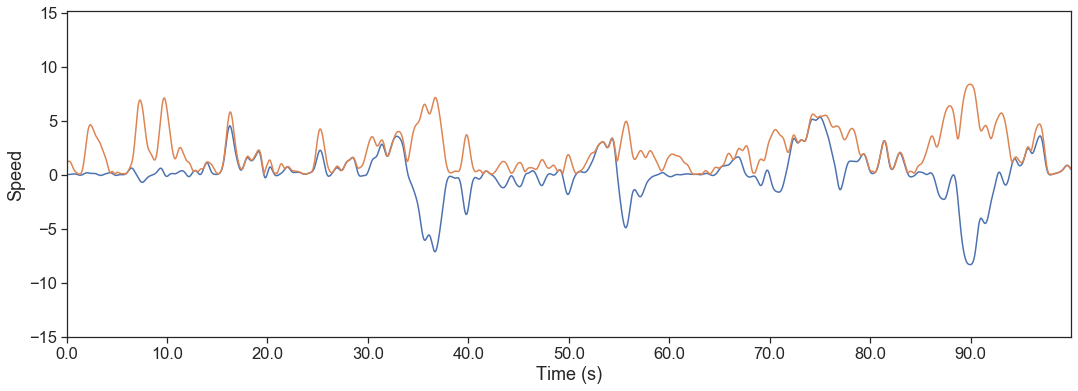

In [326]:
#here plot speed and do a bit of cleanup

plt.figure(figsize=(18,6))
#position[np.logical_not(np.isfinite(position[:,0])),:] = 0
delta_p = (position[1:] - position[:-1])
delta_p[np.logical_not(np.isfinite(delta_p[:,0])),:] = 0
delta_p[np.sum(np.abs(delta_p),axis=1)>20,:] = 0
#delta_p[np.sum(np.abs(delta_p),axis=1)<2,:] = 0

delta_p = ndi.gaussian_filter1d(delta_p,8,axis=0)
#delta_p[]
speed = np.concatenate([[0],np.sqrt(np.sum(delta_p**2,axis=1))])
plt.plot(delta_p[:,0])
plt.plot(speed)
plt.ylabel("Speed")
plt.xlabel("Time (s)")
#plt.plot(ndi.gaussian_filter1d(delta_p[:,0],7))

plt.xlim(0,3000)
plt.xticks(np.arange(0,3000,300),np.arange(0,3000,300)/30.)
#plt.ylim(-10,10)
print()

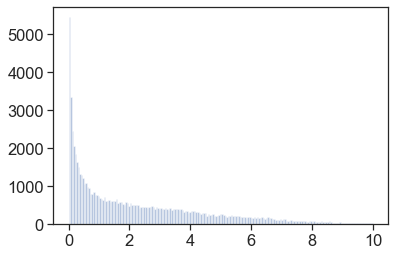

In [327]:
#Distribution of running speeds (I think in cm/s)
seaborn.distplot(speed[np.isfinite(speed)],kde=0,bins=np.linspace(0,10,num=200))
#plt.xlim(0,100)

In [328]:
clr_ = seaborn.color_palette('RdBu_r',n_colors=len(position[:,0]))

In [329]:
#clean up position data from when there was a hand or sth
for i in range(1,position.shape[0]):
    if np.abs(position[i-1,:]-position[i]).sum()>100:
        position[i] = position[i-1]

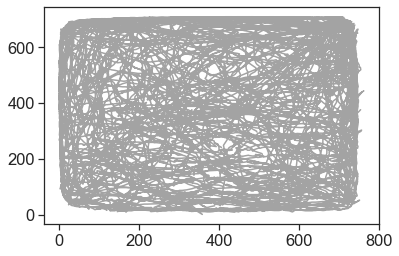

In [330]:
#plot positions
n_ = 1
plt.plot(position[speed>2,0],position[speed>2,1],color='k',alpha=.4)


In [331]:
+51685512192/384/2

67298844.0

In [332]:
np.max(sync_messages_spk)

76120824.0

In [333]:
+51685512192/384

134597688.0

In [334]:
def get_n_samples_first_half(session_data_path,divisor=384*2):
    """ Divisor is 384 channels * 2bits per int16"""
    pth = os.path.join(session_data_path,[i for i in os.listdir(session_data_path) if 'stitch_info' in i][0])
    with open(pth,'r') as f:
        lines = f.readlines()
    size1 = int(re.findall(r':\s([0-9]*)',lines[1])[0])
    return int(size1/divisor)


In [335]:
offset_samples = get_n_samples_first_half(root_path)

In [336]:
len(sync_messages_cam)

491

In [337]:
len(sync_messages_spk)

489

In [338]:
#+86272944
aligner = Rsync_aligner(sync_messages_spk+offset_samples,sync_messages_cam,units_A=30/30000.,units_B=1)

In [339]:
def gaussian_kernel(win_size, sigma):
    t = np.arange(win_size)
    x, y = np.meshgrid(t, t)
    o = (win_size - 1) / 2
    r = np.sqrt((x - o)**2 + (y - o)**2)
    scale = 1 / (sigma**2 * 2 * np.pi)
    return scale * np.exp(-0.5 * (r / sigma)**2)

In [340]:
def get_rate_map(aligned_spike_times,position,start=None,end=None):
    resp_arr = np.zeros([1000,1000])
    if start is not None:
        aligned_spike_times = aligned_spike_times[aligned_spike_times>start]
    if end is not None:
        aligned_spike_times = aligned_spike_times[aligned_spike_times<start]

    for spk in aligned_spike_times:
        tmp_ = np.zeros([1000,1000])
        at_pos = position[i]
        xp,yp = at_pos.astype(int)
        #tmp_ = np.zeros([1000,1000])
        resp_arr[2*dd_+xp-dd_:2*dd_+xp+dd_,2*dd_+yp-dd_:2*dd_+yp+dd_] += g
    return resp_arr

In [341]:
def filter_nan_gaussian_david(arr, sigma):
    """Allows intensity to leak into the nan area.
    According to Davids answer:
        https://stackoverflow.com/a/36307291/7128154
    """
    gauss = arr.copy()
    gauss[np.isnan(gauss)] = 0
    gauss = ndi.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)

    norm = np.ones(shape=arr.shape)
    norm[np.isnan(arr)] = 0
    norm = ndi.gaussian_filter(
            norm, sigma=sigma, mode='constant', cval=0)

    # avoid RuntimeWarning: invalid value encountered in true_divide
    norm = np.where(norm==0, 1, norm)
    gauss = gauss/norm
    gauss[np.isnan(arr)] = np.nan
    return gauss

In [342]:
def get_split_half_correlations(aligner,spkC,spkT,position,speed,SPEED_THRESH=2):
    
    #speed = np.concatenate([[0]*2,speed])
    n_timepoints = position.shape[0]
    half = int(np.floor(n_timepoints/2.))
    position1 = position[:half]
    position2 = position[half:]
    print(len(speed[:half]),len(position[:half]))
    
    ixs = np.where(np.logical_and(np.all(np.isfinite(position1),axis=1),speed[:half]>SPEED_THRESH))[0]
    occupancy_map1,_,_ = np.histogram2d(position1[ixs,0],position1[ixs,1],bins=np.linspace(0,780,num=51))
    
    ixs = np.where(np.logical_and(np.all(np.isfinite(position2),axis=1),speed[half:]>SPEED_THRESH))[0]
    occupancy_map2,_,_ = np.histogram2d(position2[ixs,0],position2[ixs,1],bins=np.linspace(0,780,num=51))
    
    
    ccs = []
    for unit_nr in single_units:
        sys.stdout.write('\r{}/{}'.format(unit_nr,single_units[-1]))
        spk_unit = spkT[np.where(spkC==unit_nr)[0]]


        aligned_T = aligner.A_to_B(spk_unit)
        #get the spikes that are in bounds for position encoding
        spks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
        used_spikes = aligned_T[spks_unit_in_bounds].astype('int')
        used_spikes = np.array([i for i in used_spikes if speed[i]>SPEED_THRESH])

        used_spikes_half1 = used_spikes[used_spikes<half]
        #print(used_spikes_half1)
        #break
        used_spikes_half2 = used_spikes[used_spikes>=half]

        if len(used_spikes_half1)>0 and len(used_spikes_half2)>0:
            posS = position[used_spikes_half1] 
            spike_poss,_,_ = np.histogram2d(posS[:,0],posS[:,1],bins=np.linspace(0,780,num=51))

            norm_firing = spike_poss/occupancy_map1
            norm_smth_half1 = filter_nan_gaussian_david(norm_firing,2)
            norm_smth_half1[np.logical_not(np.isfinite(norm_smth_half1))] = 0
            #print(len(used_spikes_half2))
            #print(norm_smth.sum(),occupancy_map2.sum())
            #break

            posS = position[used_spikes_half2] 
            spike_poss,_,_ = np.histogram2d(posS[:,0],posS[:,1],bins=np.linspace(0,780,num=51))
            norm_firing = spike_poss/occupancy_map2
            norm_smth_half2 = filter_nan_gaussian_david(norm_firing,2)
            norm_smth_half2[np.logical_not(np.isfinite(norm_smth_half2))] = 0
            ixs = np.logical_and(np.isfinite(norm_smth_half1.flatten()),
                                 np.isfinite(norm_smth_half2.flatten()))
            ccs.append(np.corrcoef(norm_smth_half1.flatten()[ixs],norm_smth_half2.flatten()[ixs])[0,1])
        else:
            ccs.append(np.nan)
    return np.array(ccs)


In [343]:
ccs = get_split_half_correlations(aligner,spkC,spkT,position,speed,SPEED_THRESH=3)

38458 38458
48/679

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


679/679

In [344]:
single_units

array([  9,  14,  15,  17,  18,  20,  21,  24,  27,  28,  31,  32,  37,
        40,  43,  46,  47,  48,  52,  54,  56,  58,  59,  60,  63,  64,
        66,  67,  71,  84,  85,  86,  93,  95,  96, 101, 107, 109, 110,
       113, 114, 116, 118, 120, 121, 124, 128, 129, 145, 146, 150, 151,
       152, 153, 154, 158, 165, 168, 170, 174, 176, 177, 181, 184, 186,
       189, 195, 197, 200, 202, 203, 204, 207, 208, 210, 212, 214, 217,
       220, 223, 224, 230, 236, 237, 246, 251, 255, 256, 260, 261, 267,
       269, 275, 277, 281, 284, 285, 286, 289, 294, 299, 300, 304, 305,
       306, 307, 308, 309, 310, 316, 318, 319, 322, 324, 326, 328, 334,
       338, 341, 342, 343, 345, 346, 351, 357, 359, 362, 364, 367, 369,
       370, 374, 375, 379, 380, 381, 386, 388, 389, 392, 395, 397, 399,
       408, 410, 412, 415, 418, 419, 422, 423, 425, 429, 431, 434, 435,
       463, 465, 468, 472, 473, 474, 475, 477, 478, 479, 481, 482, 483,
       487, 490, 491, 499, 502, 504, 505, 507, 509, 510, 513, 51

Text(0.5, 0, 'Correlation coeffient between \ndata halves')

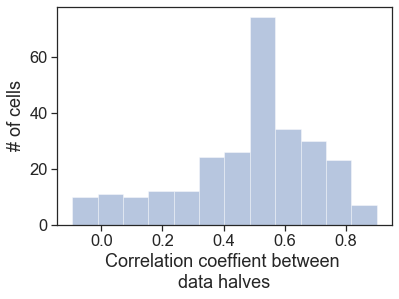

In [345]:
seaborn.distplot(ccs[np.isfinite(ccs)],kde=0)
plt.ylabel("# of cells")
plt.xlabel("Correlation coeffient between \ndata halves")

# get spatial maps 

In [346]:
all_resp_arr = []
SPEED_THRESH = 1
SMOOTHING_FACTOR = 2

ixs = np.where(np.logical_and(np.all(np.isfinite(position),axis=1),
                              speed>SPEED_THRESH))[0]
occupancy_map,_,_ = np.histogram2d(position[ixs,0],position[ixs,1],bins=np.linspace(0,780,num=51))
#occupancy_map = filter_nan_gaussian_david(occupancy_map,3)
for unit_nr in single_units:
    spk_unit = spkT[np.where(spkC==unit_nr)[0]]


    aligned_T = aligner.A_to_B(spk_unit)
    #get the spikes that are in bounds for position encoding
    spks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
    used_spikes = aligned_T[spks_unit_in_bounds].astype('int')
    used_spikes = np.array([i for i in used_spikes if speed[i]>SPEED_THRESH])
    if len(used_spikes)>0:
        posS = position[used_spikes]
        tot_spikes = len(used_spikes)
        spike_poss,_,_ = np.histogram2d(posS[:,0],posS[:,1],bins=np.linspace(0,780,num=51))

        norm_firing = spike_poss/occupancy_map
        norm_smth = filter_nan_gaussian_david(norm_firing,SMOOTHING_FACTOR)
        norm_smth[np.logical_not(np.isfinite(norm_smth))] = 0

        all_resp_arr.append([unit_nr,norm_smth,tot_spikes,np.max(norm_smth)*30])
    else:
        all_resp_arr.append([unit_nr,np.zeros([50,50]),0,0])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


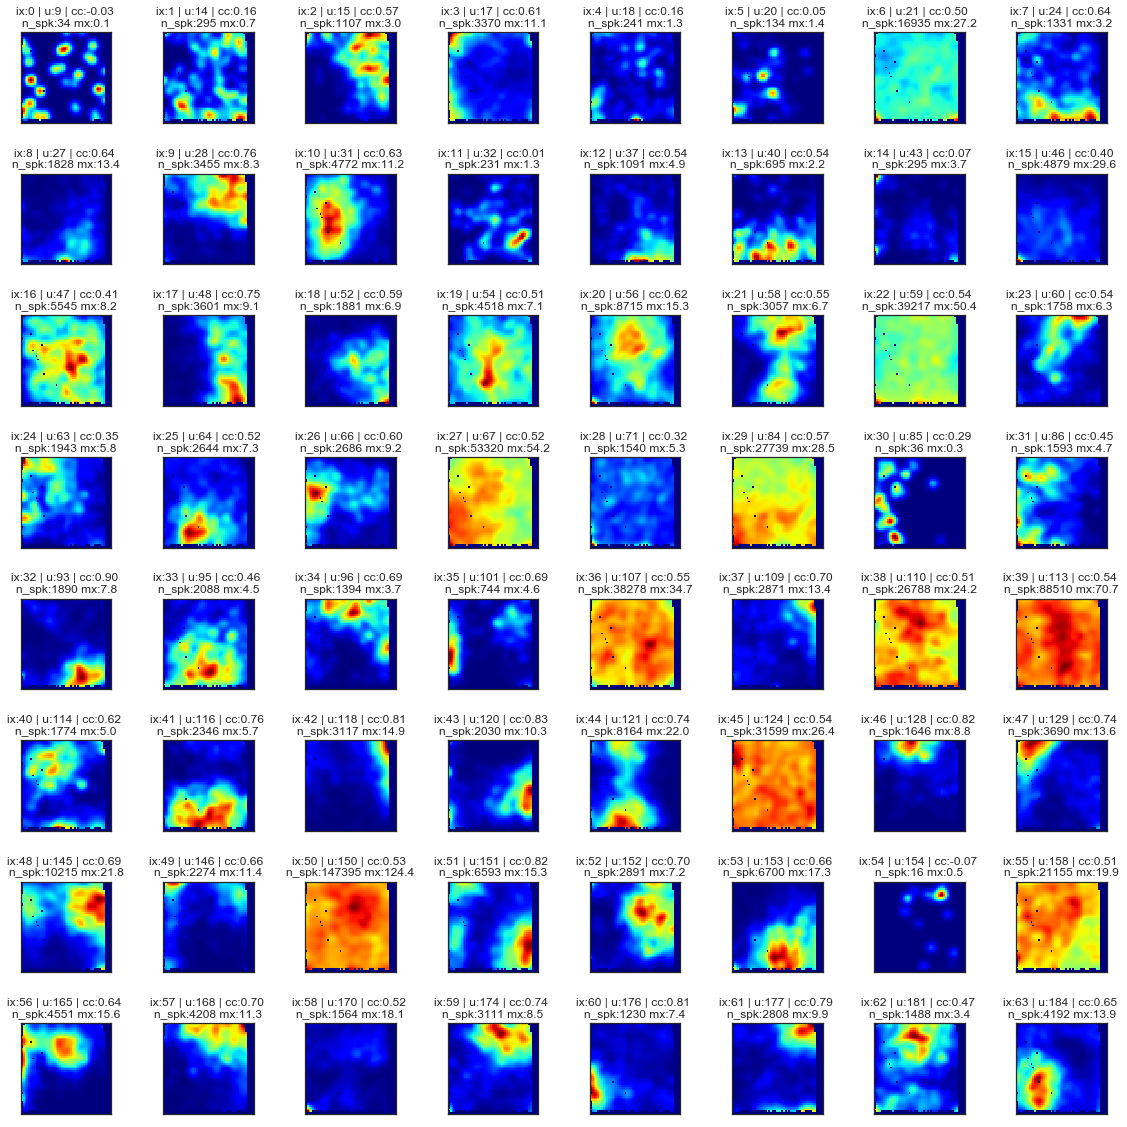

In [348]:

#plot spatial responses of 64 cells at a time. Change n64 to other ints to view the next ones
plt.figure(figsize=(16,16))
kk = 1

n64 =0
for ix in range(n64*64,(n64+1)*64):
    try:
        unit_nr,resp_map,tot,mx = all_resp_arr[ix]
        plt.subplot(8,8,kk)
        plt.title('ix:{} | u:{} | cc:{:.2f} \nn_spk:{} mx:{}'.format(ix,unit_nr,ccs[ix],tot,np.round(mx,decimals=1)),fontsize=12)
        #resp_map = 
        #resp_map[np.isnan(resp_map)] = 0
        plt.imshow(resp_map,cmap='jet',interpolation='None')#,vmin=.0,vmax=.2)
        #plt.xlim(50,1050)
        #plt.ylim(50,1050)
        plt.xticks([])
        plt.yticks([])

        kk += 1
    except ValueError:
        break
plt.tight_layout()